#To have an access from gmail account to any dataset which is already uploaded therein we need this code section which is shown below. 

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1CEWltiTJloYdb8rJh636BYdYrJf9mwUD'}) 
downloaded.GetContentFile('Botswana.mat')

In [ ]:
downloaded1 = drive.CreateFile({'id':'1zg4siTnoky6UgB_-VOvkb44JCel3_T6Z'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('Botswana_gt.mat')

In [ ]:
%load_ext tensorboard
import datetime, os

In [ ]:
!pip install -q keras
!pip install h5py ppyaml
!pip install spectral
import spectral

ERROR: Could not find a version that satisfies the requirement ppyaml (from versions: none)
ERROR: No matching distribution found for ppyaml
     |████████████████████████████████| 184kB 6.5MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212938 sha256=33993b07e5753ad5a3aa8f870a6afff5f4e66ff3cafae735a8ddbd27bc4bfc08
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


#We have to import more libraries so that our work become sucessful

In [ ]:

from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import seaborn as sn
import keras
from sklearn.utils import class_weight
from keras import backend as A
from keras.backend import sigmoid
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.layers import BatchNormalization,Dense, Dropout, Activation, Flatten, Conv2D , Conv3D,ConvLSTM2D,MaxPooling2D, Reshape,Input,MaxPooling3D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils.generic_utils import get_custom_objects
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D,Reshape,Conv1D
from keras.datasets import cifar10
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPooling1D,AveragePooling1D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding3D, BatchNormalization, Flatten, Conv2D, AveragePooling3D, MaxPooling2D, GlobalMaxPooling2D
print(tf.__version__)
print(tf.__version__)
orig = loadmat('Botswana.mat')
gt= loadmat('Botswana_gt.mat')


print(orig.keys())
print(gt.keys())

2.5.0
2.5.0
dict_keys(['__header__', '__version__', '__globals__', 'Botswana'])
dict_keys(['__header__', '__version__', '__globals__', 'Botswana_gt'])


In [ ]:
orig['Botswana'].shape
gt['Botswana_gt'].shape


(1476, 256)


#Define some fuctions like split of training testing ratio, dimension reduction technique and creating image cubes all these is shown below blocks cosecutively.

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.decomposition import PCA 
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesOrig = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesGt = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesOrig[patchIndex, :, :, :] = patch
            patchesGt[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesOrig = patchesOrig[patchesGt>0,:,:,:]
        patchesGt = patchesGt[patchesGt>0]
        patchesGt -= 1
    return patchesOrig, patchesGt

In [ ]:
X=orig['Botswana']
y= gt['Botswana_gt']
X.shape, y.shape

((1476, 256, 145), (1476, 256))

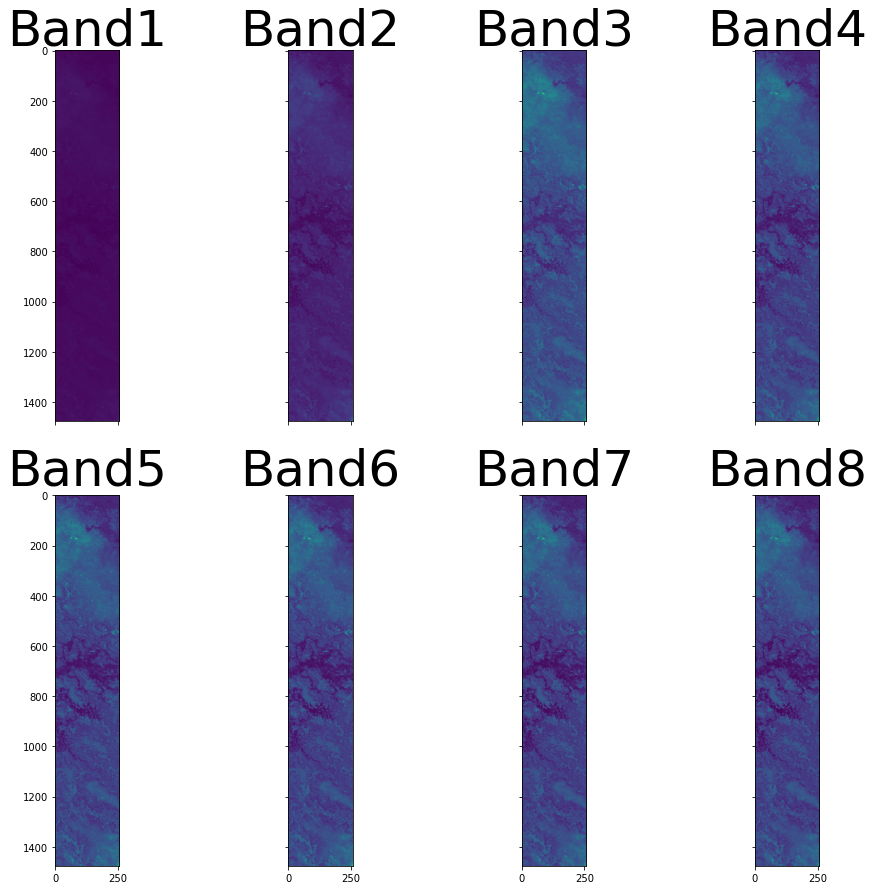

In [ ]:
fig, axes = plt.subplots(2,4, True, True, figsize=(15,15))
plt.rcParams['font.size'] = '20'
for numb, axe in enumerate(axes.flat):
    axe.imshow(X[:,:,numb])
    axe.set_title('Band'+''+str(numb+1),fontsize=50)
    
fig.subplots_adjust(wspace=.7, hspace=.2)
plt.show()

In [ ]:
K = X.shape[2]

In [ ]:
K = 11
X,pca = applyPCA(X,numComponents=K)
X.shape

(1476, 256, 11)

In [ ]:
test_ratio = 0.7
windowSize = 25

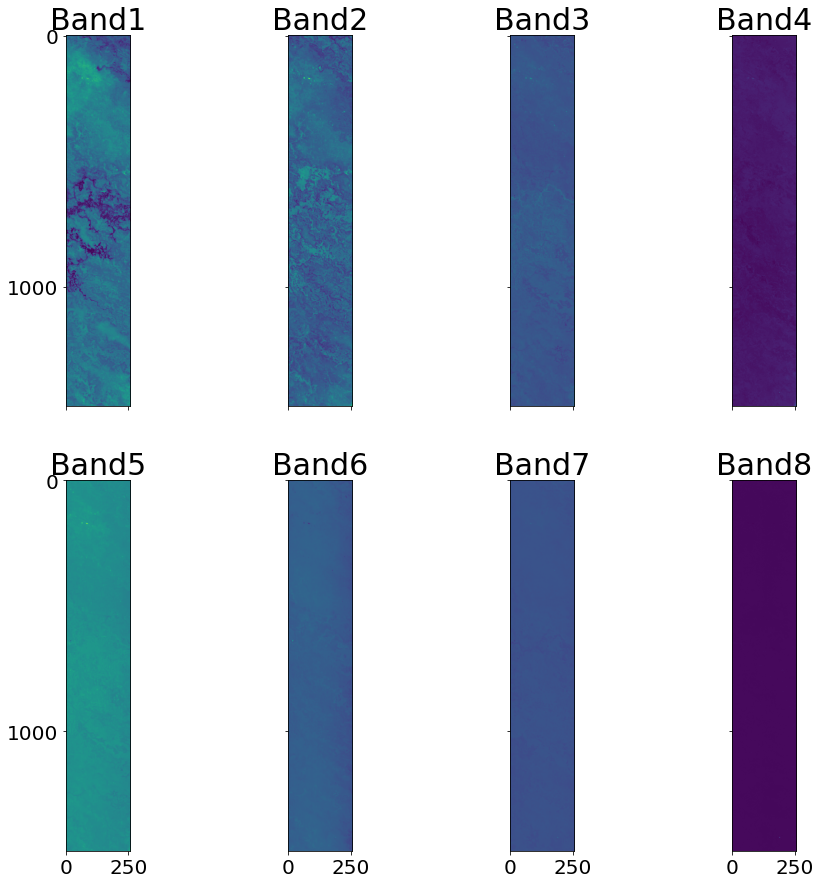

In [ ]:
fig, axes = plt.subplots(2,4, True, True, figsize=(15,15))
plt.rcParams['font.size'] = '80'
for numb, axe in enumerate(axes.flat):
    axe.imshow(X[:,:,numb])
    axe.set_title('Band'+''+str(numb+1),fontsize=30)
    
fig.subplots_adjust(wspace=.3, hspace=.2)
plt.show()

In [ ]:

X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((3248, 25, 25, 11), (3248,))

In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((974, 25, 25, 11), (2274, 25, 25, 11), (974,), (2274,))

In [ ]:

Xtrain = np.reshape(Xtrain, (Xtrain.shape[0],Xtrain.shape[3],Xtrain.shape[1], Xtrain.shape[2]))
#Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(974, 11, 25, 25)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(974, 14)

In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import json
import math
import keras
import cv2
import tensorflow as tf
import gc
import os
import numpy as np
import pandas as pd
import scipy
import itertools
import seaborn as sn
import matplotlib.pyplot as plt
import scipy.io as sio
from PIL import Image
from keras import layers, backend as A
#from keras.applications import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.utils.generic_utils import get_custom_objects
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.backend import sigmoid
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from tqdm import tqdm
from functools import partial
from collections import Counter
from operator import truediv
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Activation, Flatten, Conv2D, Conv3D, MaxPool2D, MaxPooling3D, Reshape, Dropout, Input


In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, LSTM
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import json
import math
import keras
import cv2
import tensorflow as tf
import gc
import os
import numpy as np
import pandas as pd
import scipy
import itertools
import seaborn as sn
import matplotlib.pyplot as plt
import scipy.io as sio
from PIL import Image
from keras import layers, backend as A

from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.utils.generic_utils import get_custom_objects
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.backend import sigmoid
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
from tqdm import tqdm
from functools import partial
from collections import Counter
from operator import truediv
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential


In [ ]:
S = windowSize
L = K
output_units = 9

In [ ]:
input_shape= Xtrain[0].shape
print(input_shape)

(11, 25, 25)


#Model Training and Testing

In [ ]:
def convolutional_block(X, f, filters, s = 2):

    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First layer 
    X = Conv2D(F1, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv2D(F1, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv2D(F1, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv2D(F2, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv2D(F2, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv2D(F2, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv2D(F2, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv2D(F2, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv2D(F2, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    X = Conv2D(F2, kernel_size =(1, 1), strides = (s,s))(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3)(X)  # normalization on channels
    X = Activation('relu')(X)
    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), padding = 'valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
from sklearn.model_selection import KFold
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

In [ ]:
def ResNet50(input_shape = (11, 25,25), classes = 14):
   for train, test in kfold.split(Xtrain, ytrain):
      X_input = Input(input_shape)
      X = ZeroPadding2D((2, 2))(X_input)

    # Zero-Padding
     
      
      # Stage 1
      X = Conv2D(64, (10, 10), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
      X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
      X = Activation('relu')(X)
      X = convolutional_block(X, f = 3, filters = [64,64, 256], s = 1)
      #X = identity_block(X, 3, [64, 64, 256])
      
    
      # AVGPOOL
      #X = X.shape
      #conv_layer3 = Reshape((X[1], X[2]*X[3]))(X)
      X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
      X_shape = X.shape
      
      lstm_layer3 = Reshape((X_shape[1],X_shape[2]*X_shape[3]))(X)
      X=(LSTM(400,  return_sequences =True))(lstm_layer3)
      X = Flatten()(X)
      X=Dense(256,activation='relu')(X)
      X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
      
      
      # Create model
      model = Model(inputs = X_input, outputs = X, name='ResNet50')
      model.compile(loss='categorical_crossentropy',optimizer='adam',
                  metrics=['accuracy'])
      
      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_no} ...')

        # Fit data to model
      history = model.fit(Xtrain, ytrain, batch_size=150, epochs=100)


        # Generate generalization metrics
      scores = model.evaluate(Xtrain[test], ytrain[test], verbose=0)
      print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
      acc_per_fold.append(scores[1] * 100)
      loss_per_fold.append(scores[0])
      #fold_no += 1
      return model

In [ ]:
model = ResNet50(input_shape = ( 11, 25, 25), classes = 14)




------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
7/7 [==============================] - 5s 102ms/step - loss: 2.4593 - accuracy: 0.1526
Epoch 2/100
7/7 [==============================] - 1s 99ms/step - loss: 1.1328 - accuracy: 0.6892
Epoch 3/100
7/7 [==============================] - 1s 101ms/step - loss: 0.4335 - accuracy: 0.8669
Epoch 4/100
7/7 [==============================] - 1s 100ms/step - loss: 0.1480 - accuracy: 0.9741
Epoch 5/100
7/7 [==============================] - 1s 100ms/step - loss: 0.0557 - accuracy: 0.9900
Epoch 6/100
7/7 [==============================] - 1s 99ms/step - loss: 0.0131 - accuracy: 1.0000
Epoch 7/100
7/7 [==============================] - 1s 100ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 8/100
7/7 [==============================] - 1s 98ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 9/100
7/7 [==============================] - 1s 100ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 10/100
7/

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 11, 25, 25)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 15, 29, 25)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 6, 20, 64)    160064      zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 6, 20, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
Xtest = np.reshape(Xtest, (Xtest.shape[0],Xtest.shape[3],Xtest.shape[1], Xtest.shape[2]))
Xtest.shape
Xtest.shape

(2274, 11, 25, 25)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(2274, 14)

In [ ]:
history=model.fit(Xtrain, ytrain, batch_size=50, epochs=100,validation_data=(Xtest,ytest))

Epoch 1/100
20/20 [==============================] - 3s 157ms/step - loss: 2.5414e-05 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9956
Epoch 2/100
20/20 [==============================] - 2s 104ms/step - loss: 5.1299e-05 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 0.9956
Epoch 3/100
20/20 [==============================] - 2s 103ms/step - loss: 2.4577e-05 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 0.9956
Epoch 4/100
20/20 [==============================] - 2s 104ms/step - loss: 2.1590e-05 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 0.9956
Epoch 5/100
20/20 [==============================] - 2s 103ms/step - loss: 1.4149e-05 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9956
Epoch 6/100
20/20 [==============================] - 2s 104ms/step - loss: 1.6123e-05 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy: 0.9956
Epoch 7/100
20/20 [==============================] - 2s 103ms/step - loss: 3.1002e-05 - accuracy: 1.0000 - val_loss: 0

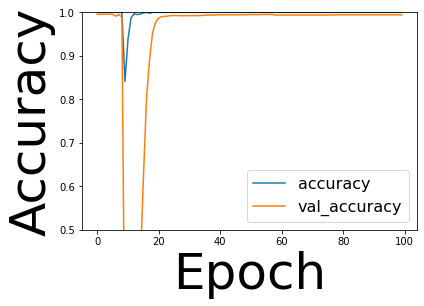

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.rcParams['font.size'] = '10'
plt.xlabel('Epoch',fontsize=50)
plt.ylabel('Accuracy', fontsize=50)
plt.ylim([0.5, 1])
plt.legend(loc='lower right', fontsize=16)


In [ ]:
overall_loss, overal_accu = model.evaluate(Xtest, ytest, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))



Overall loss = 0.02318132296204567
Overall accuracy = 0.9942831993103027



In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)

print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       1.00      1.00      1.00        71
           2       1.00      1.00      1.00       176
           3       0.95      1.00      0.97       150
           4       1.00      1.00      1.00       188
           5       1.00      0.96      0.98       188
           6       1.00      1.00      1.00       181
           7       1.00      1.00      1.00       142
           8       1.00      1.00      1.00       220
           9       1.00      1.00      1.00       174
          10       1.00      1.00      1.00       214
          11       0.98      0.98      0.98       127
          12       0.99      0.98      0.99       188
          13       1.00      1.00      1.00        66

    accuracy                           0.99      2274
   macro avg       0.99      0.99      0.99      2274
weighted avg       0.99      0.99      0.99      2274



In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

64/64 [==============================] - 2s 20ms/step - loss: 0.0232 - accuracy: 0.9943
0.9942832014072119
0.993806786054647
0.9946958093004332
[1.         1.         1.         0.94936709 1.         1.
 1.         1.         1.         1.         1.         0.9765625
 0.98930481 1.        ]


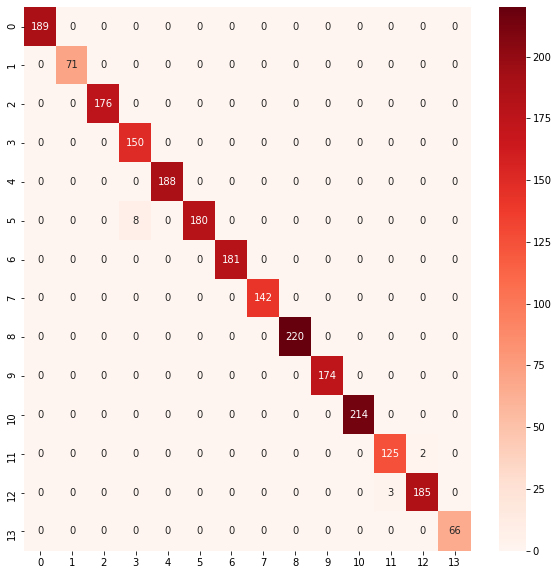

In [ ]:
oa = accuracy_score(np.argmax(ytest, axis=1), y_pred_test)
confusion = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
each_acc, aa = AA_andEachClassAccuracy(confusion)
kappa = cohen_kappa_score(np.argmax(ytest, axis=1), y_pred_test)
score = model.evaluate(Xtest, ytest, batch_size=36)
Test_Loss =  score[0]*100
Test_accuracy = score[1]*100
print(oa)
print(kappa)
print(aa)
#print (confusion)
a=confusion.diagonal()/confusion.sum(axis=0)
print(a)

plt.figure(figsize=(10,10))
sn.heatmap(confusion, annot=True, cmap=plt.cm.Reds,fmt="d")
plt.show()

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
dataset = 'BW'

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/drive/MyDrive')
    if name == 'BW':
        data = sio.loadmat(os.path.join(data_path, 'Botswana.mat'))['Botswana']
        labels = sio.loadmat(os.path.join(data_path, 'Botswana_gt.mat'))['Botswana_gt']
    
    
    return data, labels

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
def reports (model, Xtest,ytest, target_names):
    Y_pred = model.predict(Xtest)
    y_pred = np.argmax(Y_pred, axis=1)
    

    
    classification = classification_report(np.argmax(ytest, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(ytest, axis=1), y_pred)
    score = model.evaluate(Xtest, ytest, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
classes_authorized = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
num_classes = 14

target_names = [' Water','Hippo grass','Floodplain grasses 1','Floodplain grasses 2', 'Reeds','Riparian','Fire scar','Island interior','Acacia woodlands','Acacia shrunblands','Acacia grasslands','Short mopane','Mixed mopane','Exposed soils' ,]

label_dictionary = {
    0: 'Water	',
    1: 'Hippo grass	', 
    2: 'Floodplain grasses 1',
    3: 'Floodplain grasses 2', 
    4: 'Reeds	', 
    5: 'Riparian', 
    6: 'Fire scar',
    7: 'Island interior', 
    8: 'Acacia woodlands	', 
    9: 'Acacia shrunblands',
    10: 'Acacia grasslands',
    11: '	Short mopane',
    12: '	Mixed mopane',
    13: '	Exposed soils',
    
}

In [ ]:
classification, confusion, Test_loss, Test_accuracy = reports(model, Xtest,ytest, target_names)
print(classification)

72/72 [==============================] - 2s 20ms/step - loss: 0.0232 - accuracy: 0.9943
                      precision    recall  f1-score   support

               Water       1.00      1.00      1.00       189
         Hippo grass       1.00      1.00      1.00        71
Floodplain grasses 1       1.00      1.00      1.00       176
Floodplain grasses 2       0.95      1.00      0.97       150
               Reeds       1.00      1.00      1.00       188
            Riparian       1.00      0.96      0.98       188
           Fire scar       1.00      1.00      1.00       181
     Island interior       1.00      1.00      1.00       142
    Acacia woodlands       1.00      1.00      1.00       220
  Acacia shrunblands       1.00      1.00      1.00       174
   Acacia grasslands       1.00      1.00      1.00       214
        Short mopane       0.98      0.98      0.98       127
        Mixed mopane       0.99      0.98      0.99       188
       Exposed soils       1.00      1.00  

Normalized confusion matrix


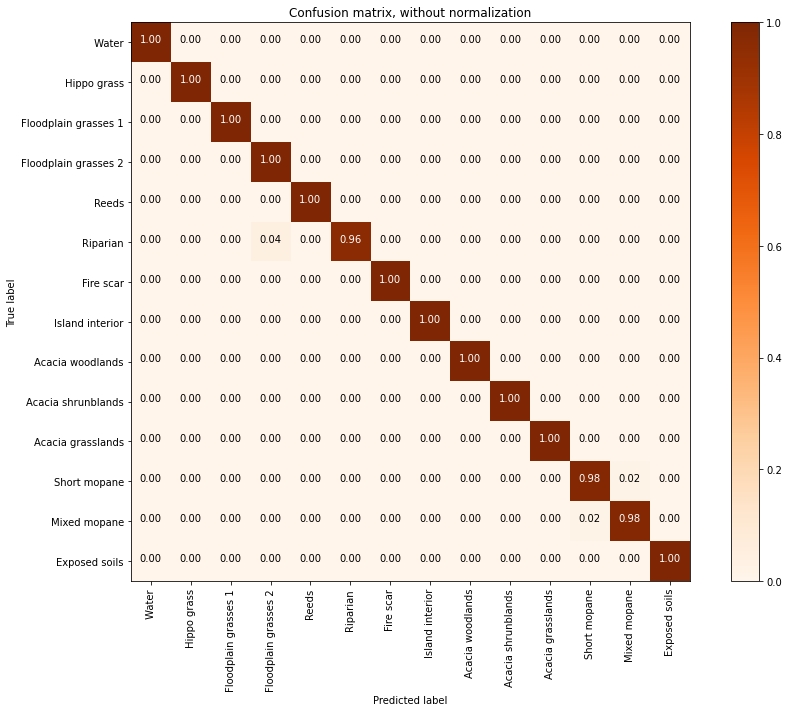

In [ ]:

plt.figure(figsize=(13, 10))
plot_confusion_matrix(confusion, classes=target_names,
                      title='Confusion matrix, without normalization')

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
dataset = 'BW'
test_ratio = 0.7
windowSize = 25

In [ ]:


label_dictionary=[' Water 270','Hippo grass 101','Floodplain grasses 1 251','Floodplain grasses 2 215', 'Reeds 269','Riparian 269','Fire scar 259','Island interior 203','Acacia woodlands 314','Acacia shrunblands 248','Acacia grasslands 305','Short mopane 181','Mixed mopane 268','Exposed soils 95']

In [ ]:
samples=[270,101,251,215,269,269,259,203,314,248,305,181,268,95]

In [ ]:
label_dictionary

[' Water 270',
 'Hippo grass 101',
 'Floodplain grasses 1 251',
 'Floodplain grasses 2 215',
 'Reeds 269',
 'Riparian 269',
 'Fire scar 259',
 'Island interior 203',
 'Acacia woodlands 314',
 'Acacia shrunblands 248',
 'Acacia grasslands 305',
 'Short mopane 181',
 'Mixed mopane 268',
 'Exposed soils 95']

In [ ]:
l=y

l=[0,1,2,3,4,5,6,7,8,9,10,11,12,13
   ]

In [ ]:
t=samples
t=[270,101,251,215,269,269,259,203,314,248,305,181,268,95]
print(t)

[270, 101, 251, 215, 269, 269, 259, 203, 314, 248, 305, 181, 268, 95]


PREDICTED IMAGE:


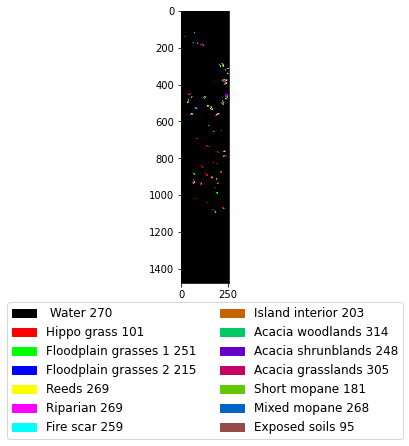

In [ ]:
from matplotlib import patches
from spectral import spy_colors
print("PREDICTED IMAGE:")
predict_image = spectral.imshow(classes =outputs.astype(int),figsize =(5,5))
labelPatches = [ patches.Patch(color=spy_colors[x]/255.,
                 label=label_dictionary[x]) for x in np.unique(l)]
plt.legend(handles=labelPatches, ncol=2, fontsize='large', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05));


In [ ]:
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,-1,image_patch.shape[0], image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

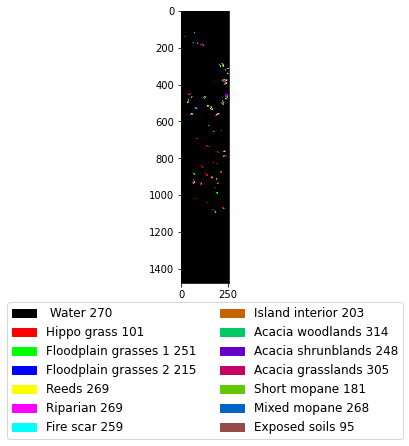

In [ ]:
ground_truth = spectral.imshow(classes =y,figsize =(5,5))
labelPatches = [ patches.Patch(color=spy_colors[t]/255.,
                 label=label_dictionary[t]) for t in np.unique(l)]
plt.legend(handles=labelPatches, ncol=2, fontsize='large', 
           loc='upper center', bbox_to_anchor=(0.5, -0.05));